In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import network, patternLib, vis
from copy import deepcopy
import random
from tqdm import tqdm

In this notebook, we figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of:

(a) the informativeness of the cue

(b) the number of other patterns stored in the network

(c) the size of the network

### A) Informativeness of Cue

We will vary the number of neurons we disturb from the original pattern

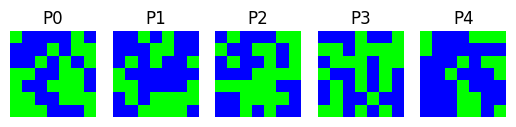

In [42]:
pattern_size = 7

# create the hopfield network of 7*7 = 49 neurons
hnet1 = network.myHopfieldNetwork(nuerons=pattern_size**2)
# create a list of 5 random patterns
plist = patternLib.get_patterns(pattern_size,5)
# learn the weights from these patterns using hebb's rule
wgts_hebb = hnet1.calculate_weights(plist)

hnet2 = network.myHopfieldNetwork(nuerons = pattern_size**2)
# learn the weights from these patterns using pseudo-inverse rule
wgts_pi = hnet2.calculate_weights(plist, rule = "pseudo-inverse")

cue = deepcopy(plist)

vis.see_pattern_list(plist)

Brief overview of Hopfield Network Performance with varying cues

Modifying 1 neurons in the pattern P0



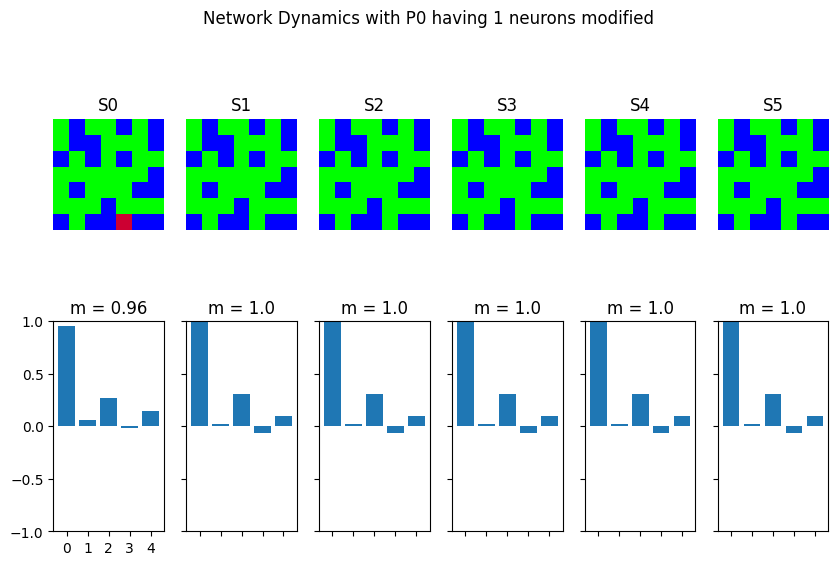


Modifying 5 neurons in the pattern P0



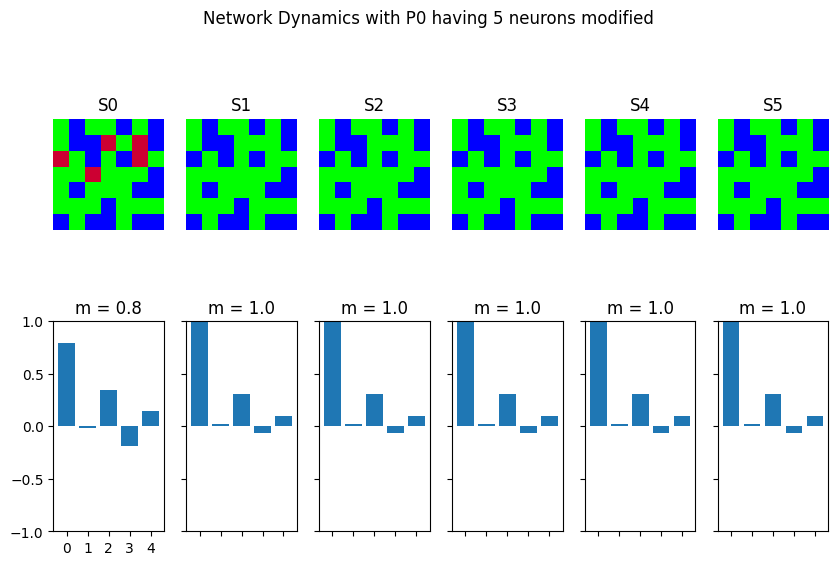


Modifying 10 neurons in the pattern P0



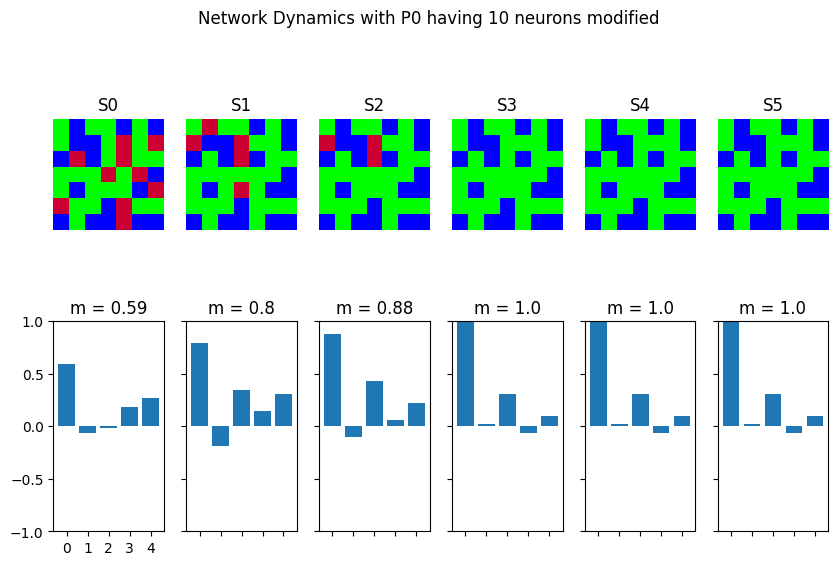


Modifying 15 neurons in the pattern P0



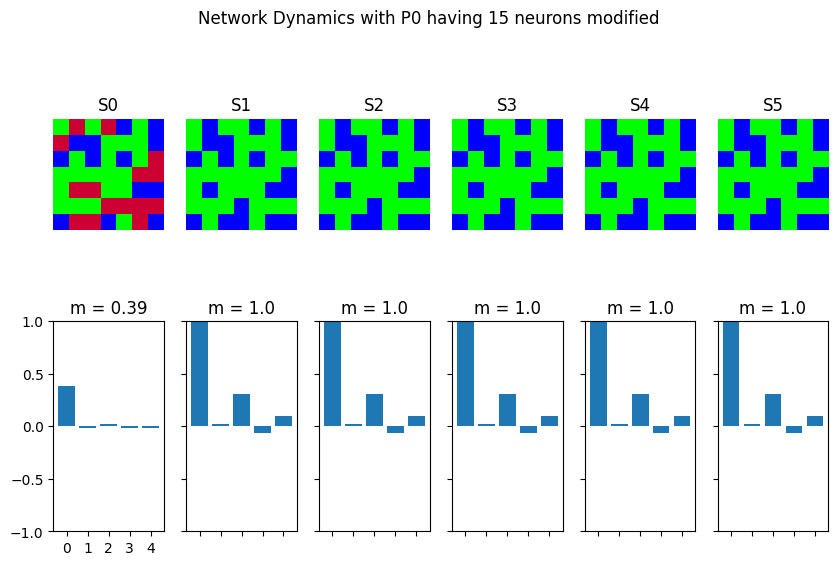


Modifying 20 neurons in the pattern P0



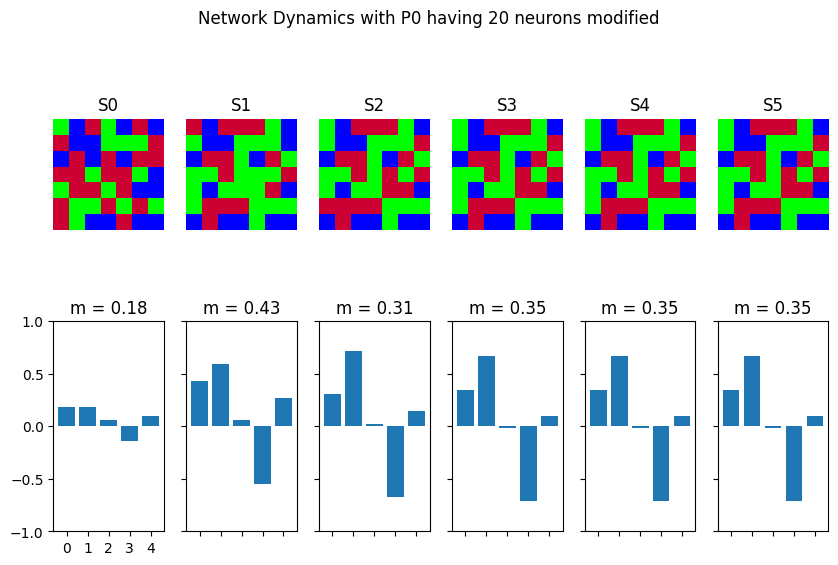


Modifying 25 neurons in the pattern P0




Modifying 30 neurons in the pattern P0




Modifying 35 neurons in the pattern P0



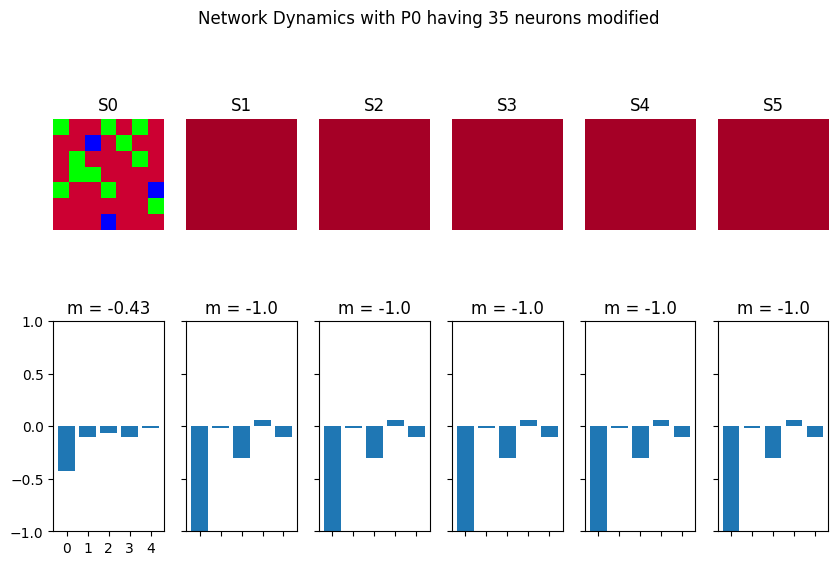


Modifying 40 neurons in the pattern P0



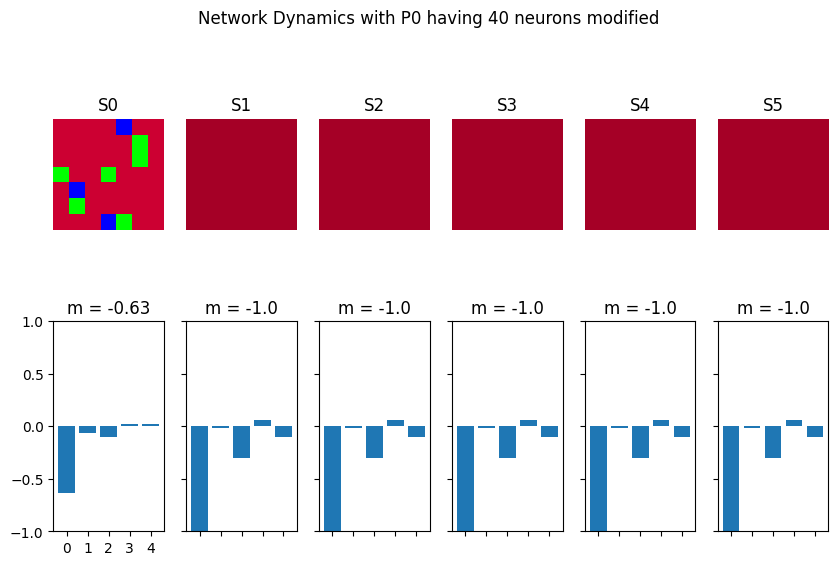

In [41]:
num_changes_list = [1,5,10,15,20,25,30,35,40]

for num_changes in num_changes_list:
    print(f"Modifying {num_changes} neurons in the pattern P0")
    S = patternLib.perturb_pattern(pattern = cue[0], num_changes=num_changes)

    # state evolution using hopfield network over 5 rounds
    state_list = hnet1.network_evolution(S,wgts_hebb,5)
    # plot the sequence of state evolution along with overlap
    vis.plot_state_sequence_and_overlap(state_list,plist,ref_idx=0,suptitle=f"Network Dynamics with P0 having {num_changes} neurons modified")
    print()

**Model performance seems to be getting worse as we modify more neurons in our initial cue. And after a certain tipoff point (when modifications > 0.5 x network size) the correlation with the original pattern is negative at the end of network evolution**

#### Measuring the average time taken to retrieve pattern as the cue informativeness deteriorates

#### Measuring the success rate of retrieving patterns as cue worsens

Calculating success rate for Hebb's Rule: 100%|██████████| 10000/10000 [00:09<00:00, 1065.57it/s]


Average success rate with 1 modification: 0.7859
Average success rate with 10 modification: 0.4094
Average success rate with 20 modification: 0.0464


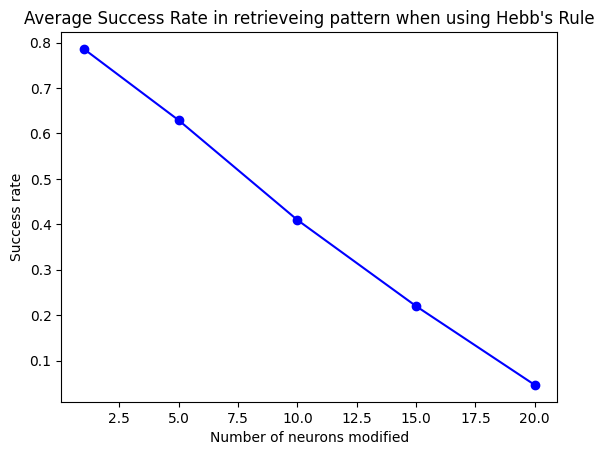

Calculating success rate for Pseudo-Inverse Rule: 100%|██████████| 10000/10000 [00:09<00:00, 1050.73it/s]


Average success rate with 1 modification: 1.0
Average success rate with 10 modification: 0.981
Average success rate with 20 modification: 0.1481


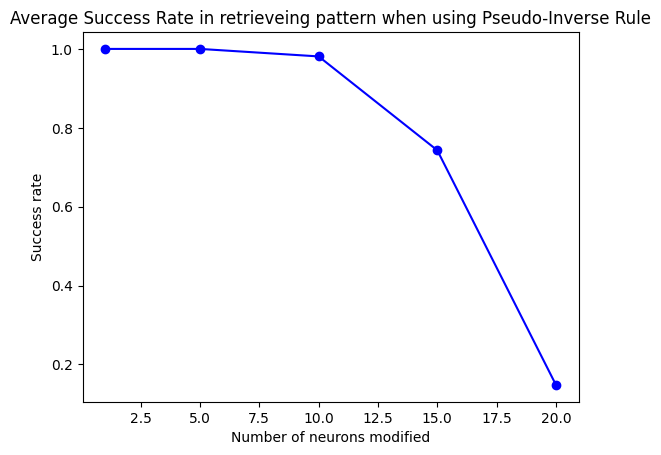

In [44]:
num_changes_list = [1,5,10,15,20]     # number of neurons to be modified
num_iterations = 10000                # number of times to run the experiment
num_rounds = 10                       # number of rounds of network evolution

i = 0

wgts_list = [wgts_hebb, wgts_pi]
models = [hnet1, hnet2]

for wgts, hnet  in zip(wgts_list, models):
    success = {num_changes: 0 for num_changes in num_changes_list}
    des = "Hebb's Rule" if i == 0 else "Pseudo-Inverse Rule"
    i += 1
    for _ in tqdm(range(num_iterations), desc = f"Calculating success rate for {des}"):
        selected_cue = random.choice(cue[:5])
        for num_changes in num_changes_list:
            S = patternLib.perturb_pattern(pattern = selected_cue, num_changes=num_changes)

            # state evolution using hopfield network
            state_list = hnet.network_evolution(S,wgts,num_rounds)
            success[num_changes] += patternLib.able_to_retrieve(selected_cue, state_list[-1])

    # Calculate the average time taken for each num_changes
    average_success_rate = {num_changes: success[num_changes] / num_iterations for num_changes in num_changes_list}

    print(f"Average success rate with 1 modification: {average_success_rate[1]}")
    print(f"Average success rate with 10 modification: {average_success_rate[10]}")
    print(f"Average success rate with 20 modification: {average_success_rate[20]}")


    plt.plot(num_changes_list, list(average_success_rate.values()), marker='o', linestyle='-', color='b')

    # Adding labels and title
    plt.xlabel('Number of neurons modified')
    plt.ylabel('Success rate')
    plt.title(f'Average Success Rate in retrieveing pattern when using {des}')

    # Display the plot
    plt.show()
    print()

**It seems to be the case that as the cue deteriorates, the success rate in retrieving the pattern decreases. Also, the pseudo-inverse rule is able to hold off the decrease for longer.**

### B) Number of other patterns stored in the network

In [28]:
pattern_size = 7

# create the hopfield network of 7*7 = 49 neurons
hnetB1 = network.myHopfieldNetwork(nuerons=pattern_size**2)
hnetB2 = network.myHopfieldNetwork(nuerons=pattern_size**2)

Basic Performance Overview

For 3 patterns in pattern_list



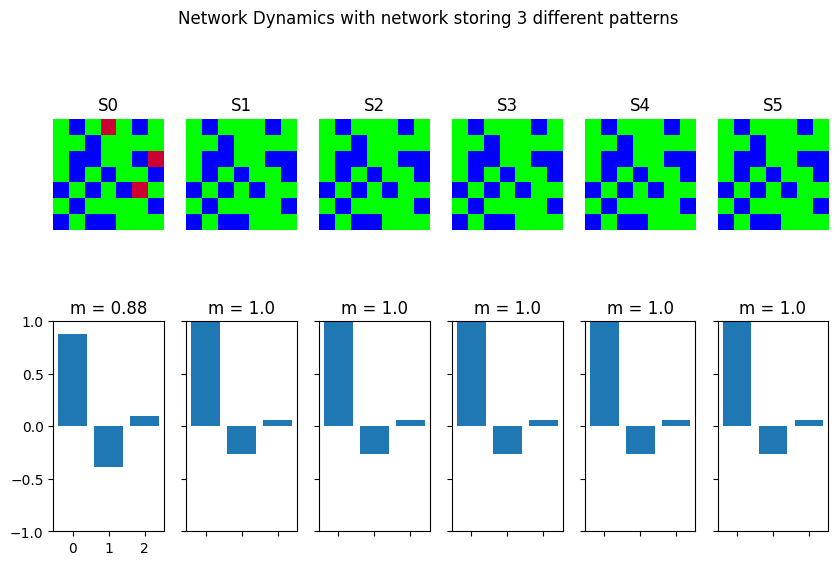


For 6 patterns in pattern_list



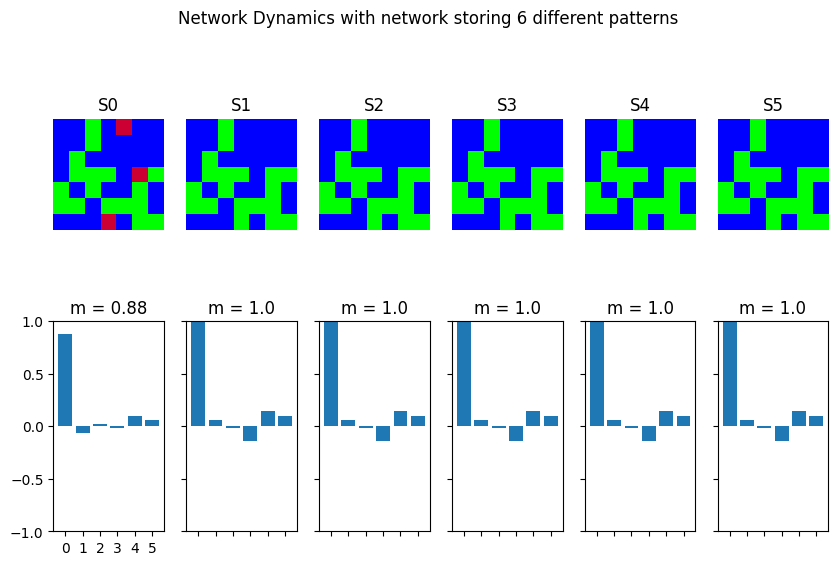


For 9 patterns in pattern_list




For 12 patterns in pattern_list



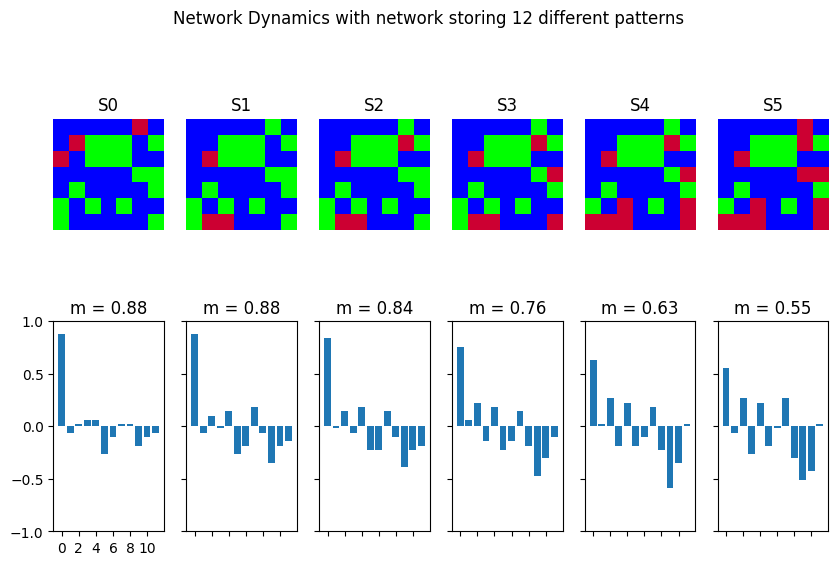


For 15 patterns in pattern_list



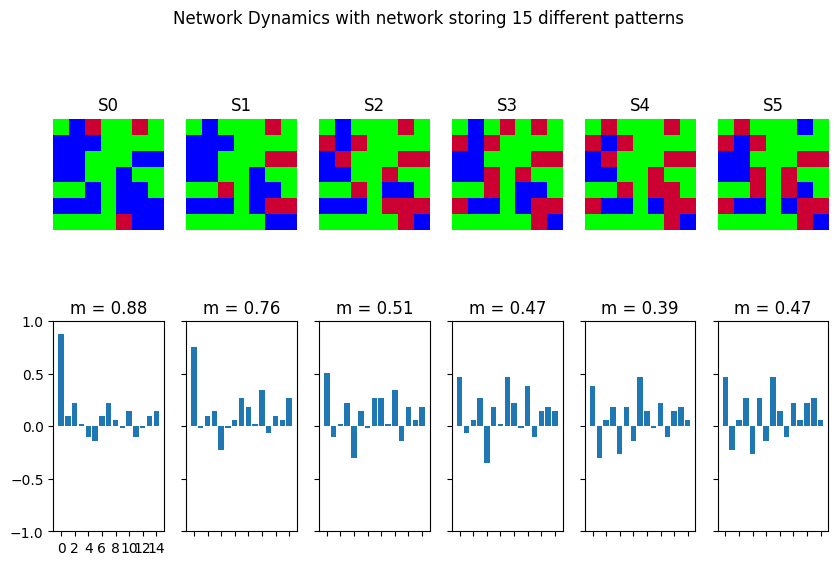

In [30]:
num_changes = 3
num_rounds = 5
num_patterns_list = [3,6,9,12,15]
for num_pattern in num_patterns_list:
    print(f"For {num_pattern} patterns in pattern_list")
    plist = patternLib.get_patterns(pattern_size,num_pattern)
    wgts = hnetB2.calculate_weights(plist)
    cue2 = deepcopy(plist)

    # changes 5 neurons in the pattern P0
    S = patternLib.perturb_pattern(pattern = cue2[0], num_changes=num_changes)
    # let the network evolve over 5 rounds
    state_list = hnetB2.network_evolution(S,wgts,num_rounds)

    vis.plot_state_sequence_and_overlap(state_list,plist,ref_idx=0,suptitle=f"Network Dynamics with network storing {num_pattern} different patterns")
    print()


**The basic hopfield network seems to worsen performance as it is required to store more patterns**

#### Success rate as a function of number of patterns

In [34]:
num_changes = [3,9]                           # number of neurons to be modified
num_iterations = 10000                        # number of times to run the experiment
num_rounds = 10                               # number of round of network evolution
num_patterns_list = [1,2,3,4,5,6,7,8,9,10]    # number of patterns to be stored in the model

i = 0

for hnet in [hnetB1, hnetB2]:
    des = "Hebb's Rule" if i == 0 else "Pseudo-Inverse Rule"
    for num_change in num_changes:
      success = {num_patterns: 0 for num_patterns in num_patterns_list}
      for num_patterns in tqdm(num_patterns_list, desc = f"Calculating success rate for {des} with {num_change} changes"):

          # create a list of patterns
          plist = patternLib.get_patterns(pattern_size,num_patterns)

          # calculate weights
          wgts = 0
          if i == 0:
            wgts = hnet.calculate_weights(plist)
          else:
            wgts = hnet.calculate_weights(plist, rule = "pseudo-inverse")

          cue = deepcopy(plist)

          for _ in range(num_iterations):
              selected_cue = random.choice(cue[:num_patterns])
              S = patternLib.perturb_pattern(pattern = selected_cue, num_changes=num_change)

              # state evolution using hopfield network
              state_list = hnet.network_evolution(S,wgts,num_rounds)
              success[num_patterns] += patternLib.able_to_retrieve(selected_cue, state_list[-1])

      # Calculate the average time taken for each num_changes
      average_success_rate = {num_patterns: success[num_patterns] / num_iterations for num_patterns in num_patterns_list}

      print(f"Average success rate with 1 pattern: {average_success_rate[1]}")
      print(f"Average success rate with 5 patterns: {average_success_rate[5]}")
      print(f"Average success rate with 10 patterns: {average_success_rate[10]}")

      plt.plot(num_patterns_list, list(average_success_rate.values()), marker='o', linestyle='-', color='b')

      # Adding labels and title
      plt.xlabel('Number of patterns in model')
      plt.ylabel('Success rate')
      plt.title(f'Average Success Rate in retrieveing pattern for {des} with {num_change} changes')

      # Display the plot
      plt.show()
      print()
    i += 1

Calculating success rate for Hebb's Rule with 3 changes: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Average success rate with 1 pattern: 1.0
Average success rate with 5 patterns: 0.8426
Average success rate with 10 patterns: 0.4049


Calculating success rate for Hebb's Rule with 9 changes: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


Average success rate with 1 pattern: 1.0
Average success rate with 5 patterns: 0.5444
Average success rate with 10 patterns: 0.0045


Calculating success rate for Pseudo-Inverse Rule with 3 changes: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Average success rate with 1 pattern: 1.0
Average success rate with 5 patterns: 1.0
Average success rate with 10 patterns: 1.0


Calculating success rate for Pseudo-Inverse Rule with 9 changes: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


Average success rate with 1 pattern: 1.0
Average success rate with 5 patterns: 0.9972
Average success rate with 10 patterns: 0.9578


**It can be seen that for our simple Hopfield Network using Hebb's rule, success rate drops drastically when we increase the number of stored patternf from 1 to 10. However, while using the Pseudo-Inverse rule, the performance more or less remains the same.**

### C) Network Size

Basic Overview

Random patterns generated initially



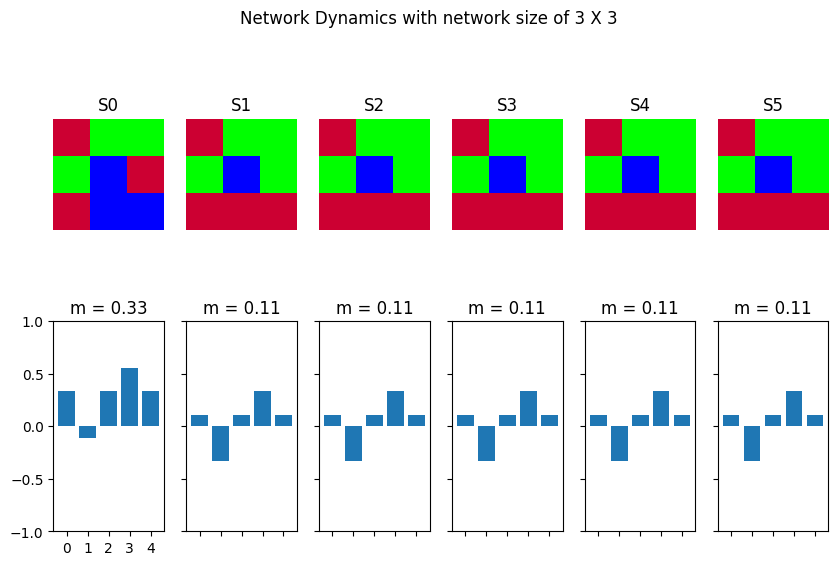


Random patterns generated initially



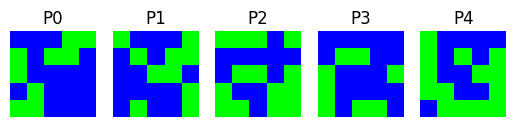

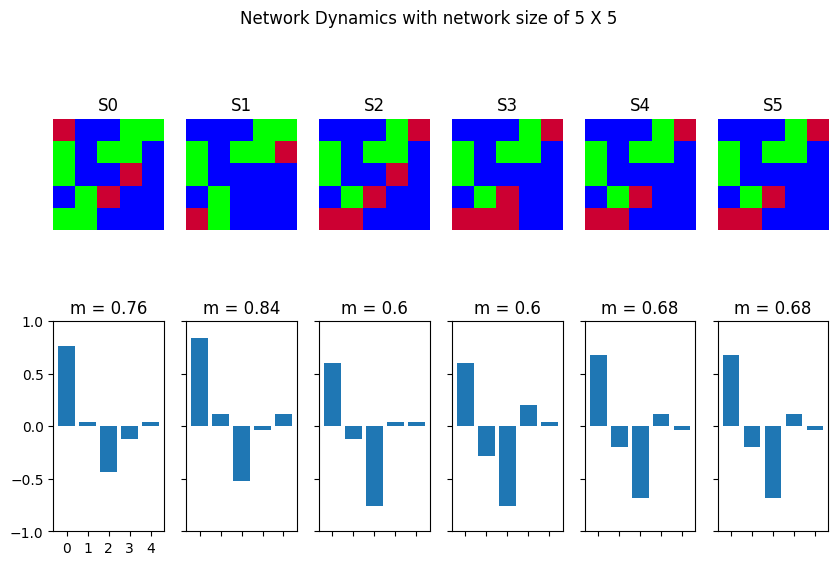


Random patterns generated initially



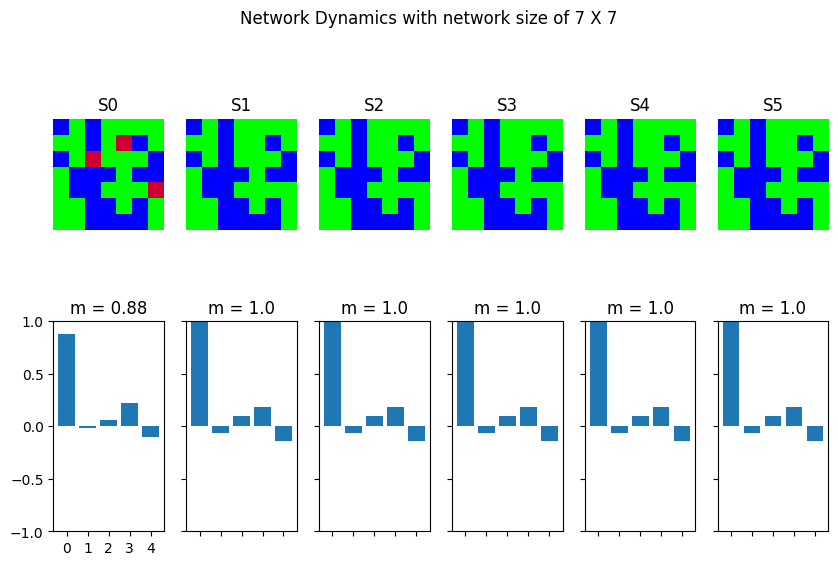


Random patterns generated initially



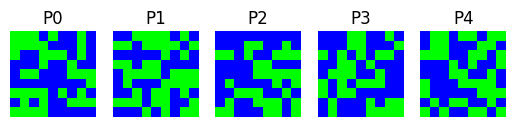

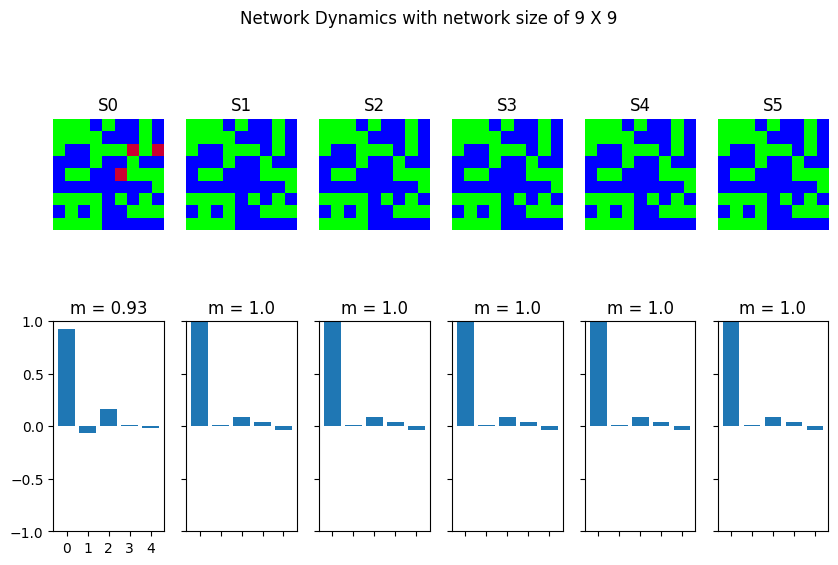


Random patterns generated initially



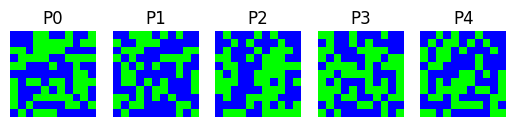

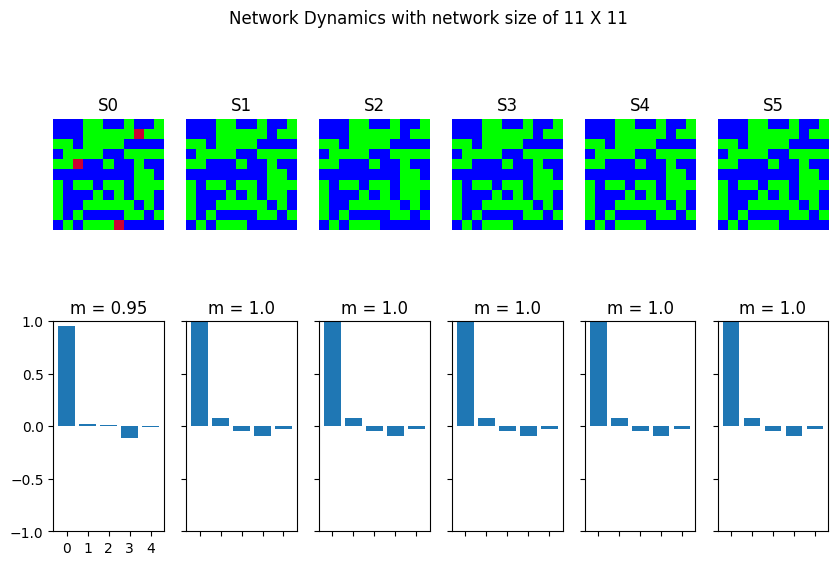


Random patterns generated initially



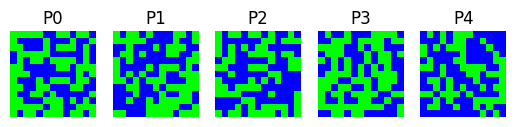

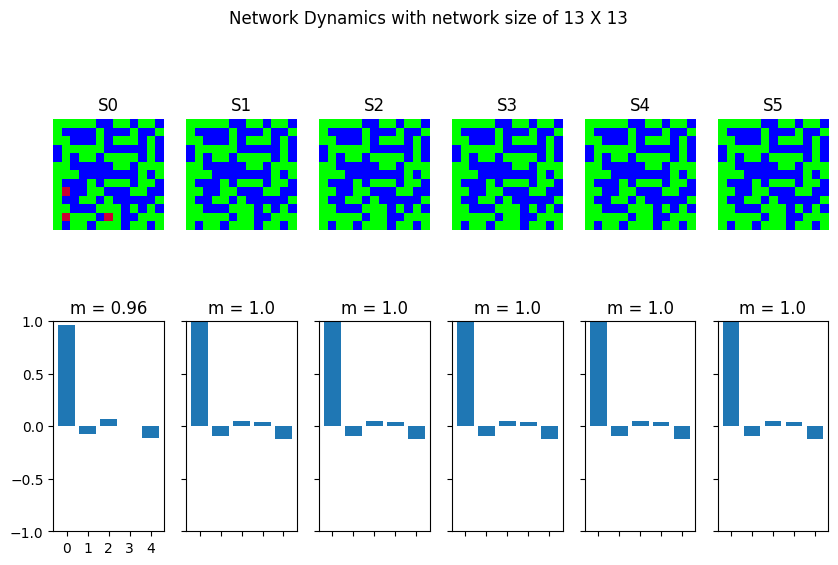


Random patterns generated initially



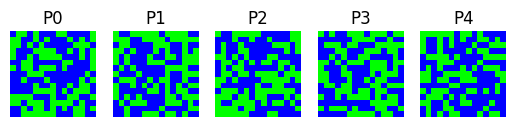

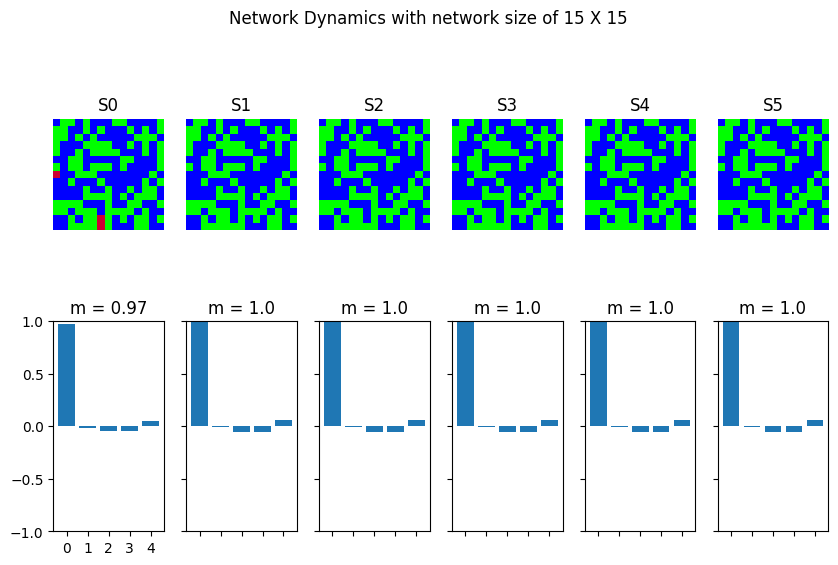

In [35]:
network_sizes = [3,5,7,9,11,13,15]        # dimension of network size
pattern_size = 5                          # number of patterns to be remembered by network
num_changes = 3                           # number of neuron changes
num_rounds = 5                            # number of rounds of network evolution

for network_size in network_sizes:

    hnet3 = network.myHopfieldNetwork(network_size**2)
    plist = patternLib.get_patterns(network_size,pattern_size)
    wgts = hnet3.calculate_weights(plist)
    print("Random patterns generated initially")
    vis.see_pattern_list(plist)

    cue = deepcopy(plist)

    S = patternLib.perturb_pattern(pattern = cue[0], num_changes = num_changes)
    state_list = hnet3.network_evolution(S,wgts,num_rounds)
    vis.plot_state_sequence_and_overlap(state_list,plist,ref_idx=0,suptitle=f"Network Dynamics with network size of {network_size} X {network_size}")
    print()


**It seems that model performance improves as the network grows larger**

#### Avg success rate as network size grows

Calculating success rate for Hebb's Rule with 3 changes: 100%|██████████| 9/9 [00:23<00:00,  2.62s/it]


Average success rate with networks size = 3X3 : 0.1733
Average success rate with networks size = 5X5 : 0.0
Average success rate with networks size = 7X7 : 0.9336


Calculating success rate for Hebb's Rule with 9 changes: 100%|██████████| 9/9 [00:25<00:00,  2.80s/it]


Average success rate with networks size = 3X3 : 0.0
Average success rate with networks size = 5X5 : 0.0
Average success rate with networks size = 7X7 : 0.849


Calculating success rate for Pseudo-Inverse Rule with 3 changes: 100%|██████████| 9/9 [00:24<00:00,  2.76s/it]


Average success rate with networks size = 3X3 : 0.0158
Average success rate with networks size = 5X5 : 0.9969
Average success rate with networks size = 7X7 : 1.0


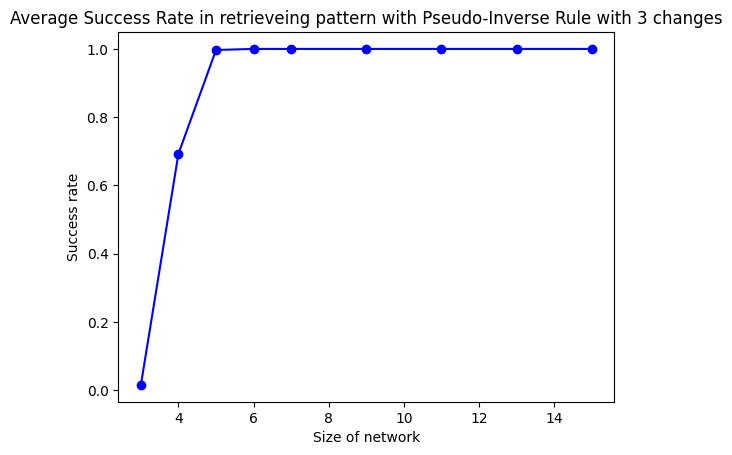

Calculating success rate for Pseudo-Inverse Rule with 9 changes: 100%|██████████| 9/9 [00:23<00:00,  2.57s/it]


Average success rate with networks size = 3X3 : 0.0
Average success rate with networks size = 5X5 : 0.1657
Average success rate with networks size = 7X7 : 0.997


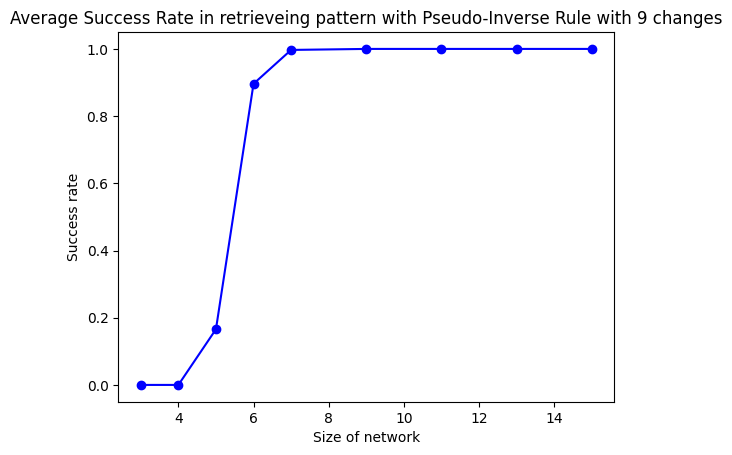

In [39]:
network_sizes = [3,4,5,6,7,9,11,13,15]            # network size
pattern_size = 5                                  # number of patterns to be remembered by network
num_changes = [3,9]                               # number of neuron changes
num_rounds = 10                                   # number of rounds of network evolution
num_iterations = 10000                            # number of times to run the experiment

for i in range(2):
    des = "Hebb's Rule" if i == 0 else "Pseudo-Inverse Rule"
    for num_change in num_changes:
      success = {network_size: 0 for network_size in network_sizes}
      average_success_rate = {}
      for network_size in tqdm(network_sizes, desc = f"Calculating success rate for {des} with {num_change} changes"):

          hnet3 = network.myHopfieldNetwork(network_size**2)
          plist = patternLib.get_patterns(network_size,pattern_size)
          wgts = 0
          if i == 0:
              wgts = hnet3.calculate_weights(plist)
          else:
              wgts = hnet3.calculate_weights(plist, rule = "pseudo-inverse")

          cue3 = deepcopy(plist)

          for _ in range(num_iterations):
              selected_cue = random.choice(cue3[:pattern_size])
              # for num_changes in num_changes_list:
              S = patternLib.perturb_pattern(pattern = selected_cue, num_changes=num_change)

              # state evolution using hopfield network
              state_list = hnet3.network_evolution(S,wgts,num_rounds)
              success[network_size] += patternLib.able_to_retrieve(selected_cue, state_list[-1])

          average_success_rate[network_size] = success[network_size] / num_iterations


      print(f"Average success rate with networks size = 3X3 : {average_success_rate[3]}")
      print(f"Average success rate with networks size = 5X5 : {average_success_rate[5]}")
      print(f"Average success rate with networks size = 7X7 : {average_success_rate[7]}")

      plt.plot(network_sizes, list(average_success_rate.values()), marker='o', linestyle='-', color='b')

      # Adding labels and title
      plt.xlabel('Size of network')
      plt.ylabel('Success rate')
      plt.title(f'Average Success Rate in retrieveing pattern with {des} with {num_change} changes')

      # Display the plot
      plt.show()

**We can clearly see the success rate increasing as the size of the network grows. The increase is obviously a bit delayed when we modify more neurons, and the increase is also steeper in case of Pseudo-inverse rule.**